In [2]:
import sys
import pandas as pd
import time
import timeit
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets


# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from clean_velocities import *
from draw_node_amount import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from reittien_erottelu import *
from isolation_forest import *
from sisään_uloskäynnit import *
from horrostila import *
from widgets import *
from plot_lapimenoajat import *

'''def timing():
    start_time = timeit.default_timer()
    #start_time = time.time()
    #return lambda x: print("{} {:.3f}s".format(x, time.time() - start_time))
    y = '{:.10f}s #'.format(timeit.default_timer() - start_time)
    return lambda x: print(f"\n#{len(y+x)*'='}#\n# {x}{y}\n#{len(y+x)*'='}#\n")
t = timing()
t("Execution time: ")'''
# tai from ... import *

'def timing():\n    start_time = timeit.default_timer()\n    #start_time = time.time()\n    #return lambda x: print("{} {:.3f}s".format(x, time.time() - start_time))\n    y = \'{:.10f}s #\'.format(timeit.default_timer() - start_time)\n    return lambda x: print(f"\n#{len(y+x)*\'=\'}#\n# {x}{y}\n#{len(y+x)*\'=\'}#\n")\nt = timing()\nt("Execution time: ")'

In [3]:
@interact_manual

def dataoptions(
    
    nodes = widgets.SelectMultiple(options= nodeIds,value=['All'],description='Node_id(s): ', disabled=False, layout=Layout(margin='0px 0px 40px 200px')),

    start_date=widgets.DatePicker(value=pd.to_datetime('2020-06-24'),description='Starting Date', layout=Layout(margin='0px 0px 0px 0px')),                      
    end_date=widgets.DatePicker(value=pd.to_datetime('2020-11-01 23:00:00'),description='Ending Date', layout=Layout(margin='-30px 0px 0px 400px')),
                           
    tuntivalitsin=widgets.SelectionRangeSlider(options=OptHours,index=[0,14],
    description='Tunnit',disabled=False,value=[8,22], layout=Layout(margin='20px 0px 0px 0px')),

   ):
   
    
    def getdata():
        
        global df
        import mysql.connector
        mydb = mysql.connector.connect(
        host="172.28.200.50",
       user="root",
        port=3306,
      passwd="insert-password-here",
        database="iiwari_org")
        
        mycursor = mydb.cursor(dictionary=True)
        
        # Paivmaarat string formaattiin
        start_date_string = "'{}'".format(str(start_date))
        end_date_string = "'{}'".format(str(end_date))
        
        
        # Sql kysely vaihtoehdot jos valittu 'All'
        if nodes[0] == 'All':
            mycursor.execute("SELECT * FROM CleanSensorData WHERE timestamp >= {} and timestamp < {}".format(start_date_string, end_date_string))
            
        # Jos vain 1 node valittu
        elif len(nodes) == 1:
            mycursor.execute("SELECT * FROM CleanSensorData WHERE node_id={} and timestamp >= {} and timestamp < {}".format(nodes[0], start_date_string, end_date_string))
        
        # Monta nodea valittuna
        else:
            mycursor.execute("SELECT * FROM CleanSensorData WHERE node_id IN {} and timestamp >= {} and timestamp < {}".format(nodes, start_date_string, end_date_string))
            
        df = pd.DataFrame(mycursor.fetchall())
        
        # Palauttaa virheilmoituksen jos dataframe on tyhja
        if len(df) == 0:
            return print("Error 01: Empty Dataset ")
        
        
        # Timestamp datetime muotoon
        df['timestamp'] = df['timestamp'].astype(str)
        df['timestamp'] = df['timestamp'].str.slice(2, -2)
        df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
        
        # Sorttaa tunnit                   
        df = df.loc[df.timestamp.dt.strftime('%-H').astype('int32') >= tuntivalitsin[0]]
        df = df.loc[df.timestamp.dt.strftime('%-H').astype('int32') <= tuntivalitsin[1]]
        
        return df
    
    df = getdata()
   
    # Haetaan valittu kuvaaja, widgeteiltä saatujen arvojen perusteella #
    return df

interactive(children=(SelectMultiple(description='Node_id(s): ', index=(0,), layout=Layout(margin='0px 0px 40p…

# Database query

In [9]:
#df = database_query("SELECT * FROM SensorData limit 10000")
#df.head()

# Histogram of x and y coordinates

x mean:  2060.571318975492
y mean:  587.6214649185986
x std:  912.9589320621584
y std:  1084.7031956998255


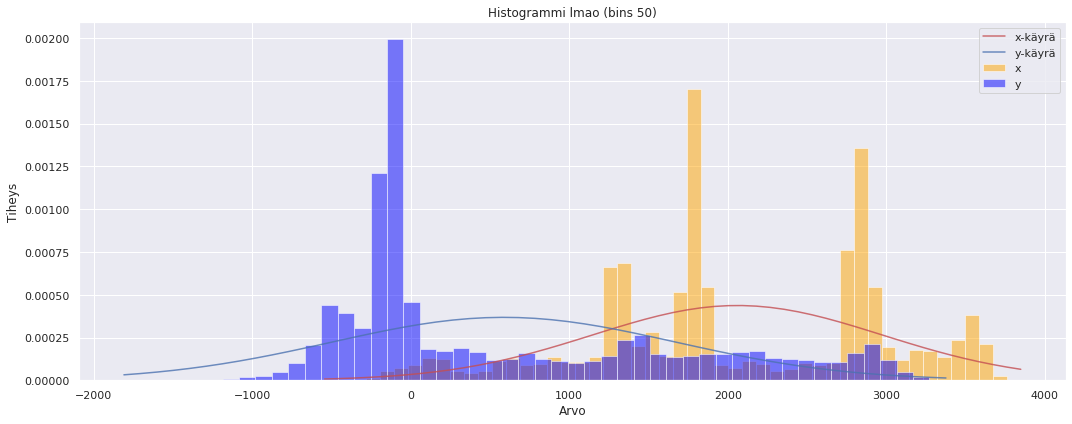

CPU times: user 2.32 s, sys: 108 ms, total: 2.43 s
Wall time: 1.01 s


In [39]:
%%time
draw_histogram(df['x'], df['y'], 50)

# Find outliers using z_score

Number of missing variables in table
 node_id      0
timestamp    0
x            0
y            0
x_grid       0
y_grid       0
grid_id      0
dtype: int64
------------------------------
Unique values in columns

uniques in node_id: 28
uniques in timestamp: 224040
uniques in x: 4169
uniques in y: 4754
uniques in x_grid: 46
uniques in y_grid: 48
uniques in grid_id: 1596
------------------------------
Number of nodes: 28
------------------------------
Outliers

Data with outliers:  553983
Ouliers removed:     456
Data after:          553527
Percent removed:    0.08 %
Percent remaining:  99.92 %
------------------------------


./Moduulit/outliers.py:70: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("outliers-in-data.png")


CPU times: user 4.19 s, sys: 116 ms, total: 4.31 s
Wall time: 4.3 s


/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


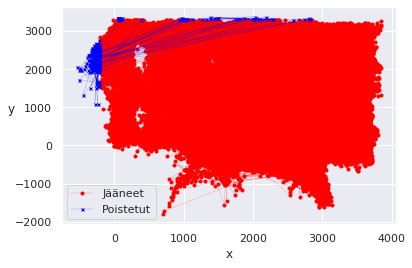

In [40]:
%%time
df1 = find_outliers(df)

Koko datasetissä (13 890 906)
- Data with outliers: 13 890 906
- Ouliers removed:    376 791
- Data after:         13 514 115

In [13]:
def clean_dataframe(df):
    
    # node_id:s to 1-32 format
    df['node_id'] = pd.factorize(df['node_id'])[0] + 1
    
    # Timestamp to datetime
    df['timestamp'] = df['timestamp'].astype(str)
    df['timestamp'] = df['timestamp'].str.slice(2, -7)
    df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
    
    # Round ms
    df.timestamp = df.timestamp.dt.round("ms")
    df.timestamp = df.timestamp.dt.tz_localize('UTC')

    # Muunnetaan Suomen aikaan. Tämä huomioi kesä- ja talviajan.
    df.timestamp = df.timestamp.dt.tz_convert('Europe/Helsinki')
    
    # Drop +00 ending
    df['timestamp'] = df['timestamp'].astype(str)
    df['timestamp'] = df['timestamp'].str.slice(0, -7)
    df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
    
    # viikonpäiväkolumni
    df['dayofweek'] = df.timestamp.dt.dayofweek
    
    print(df.timestamp.dt.hour.unique())
    print(f"{'-'*30}\nFiltering out after-hours\n")
    print("Data before filtering: ", len(df))
    print("Deleted nodes before 8:00: ",len(df) - len(df.drop(df[(df.timestamp.dt.hour < 8)].index)))
    print("Deleted nodes after 21:00: ", len(df) - len(df.drop(df[(df.timestamp.dt.hour > 21)].index)))
    print("Deleted after-hours nodes: ", (len(df.drop(df[(df.timestamp.dt.hour < 8)].index)) + len(df.drop(df[(df.timestamp.dt.hour > 21)].index))))
    # Poistetaan aukioloaikojen ulkopuolella olevat ajat
    df = df.drop(df[(df.timestamp.dt.hour < 8)].index) #dropataan kaikki 8-21 ulkopuolella olevat tunnit
    df = df.drop(df[(df.timestamp.dt.hour > 21)].index)
    df = df.reset_index(drop=True) # resetoidaan indexit, että voidaan ajaa uudet koodit
    
    # alustetaan uusi kolumni nollalla, tähän tulee kyseinen tunti kaupassa, esimerkiksi klo 8 eli aukioloajan ensimmäinen tunti on 1
    df['current_hour'] = 0
    
    # Käydään läpi timestamp ja jokaikisen tunnin kohdalle lisätään yksi tunti. Aloitetaan tunnista 8
    #Koska 8-21 välillä 15 tuntia, ajetaan tämä 15 kertaa
    for i in range(15):
        df['current_hour'].loc[df['timestamp'].dt.hour == 8+i] = i+1

    #Sunnuntaina aloitetaan kaksi tuntia myöhemmin, joten vähennetään kaksi tuntia jokaisesta hetkestä
    df['current_hour'].loc[df['timestamp'].dt.dayofweek == 6] = df['current_hour'].loc[df['timestamp'].dt.dayofweek == 6] - 2
    
    # Suodatetaan Sunnuntaitten aukioloajat
    df_temp = df[df.timestamp.dt.dayofweek == 6].index.values.tolist()
    df_new_temp = df.iloc[df_temp][df.iloc[df_temp].timestamp.dt.hour < 10]

    # Poistetaan alkuperäisestä dataframesta kyseiset arvot
    df = df.drop(df.index[df_new_temp.index.values])
    
    df = df.reset_index(drop=True)
    
    # Drop z and q columns
    df = df.drop(columns=['z','q'])
    
    bad_nodes = [13,14,18,27,32]
    
    # Poistetaan huonot nodet
    print(f"{'-'*30}\nBad nodes: {bad_nodes}\n")
    print("Amount of bad nodes", (len(df[df.node_id == 13]) + len(df[df.node_id == 14]) + len(df[df.node_id == 18]) + len(df[df.node_id == 27]) + len(df[df.node_id == 32])))
    print("Data after deleting bad nodes: ", len(df) - (len(df[df.node_id == 13]) + len(df[df.node_id == 14]) + len(df[df.node_id == 18]) + len(df[df.node_id == 27]) + len(df[df.node_id == 32])))
    print(f"{'-'*30}")
    df = df[df.node_id != 13]
    df = df[df.node_id != 14]
    df = df[df.node_id != 18]
    df = df[df.node_id != 27]
    df = df[df.node_id != 32]
    
    return df

clean_dataframe(df1)

[18 11 12 13 14 15 16 17 19 20 21 22 23  0]
------------------------------
Filtering out after-hours

Data before filtering:  23752
Deleted nodes before 8:00:  130
Deleted nodes after 21:00:  4247
Deleted after-hours nodes:  43127


KeyError: "['z' 'q'] not found in axis"

# Cleaning Node_id, timestamp, q, z columns

In [9]:
df1 = clean_dataframe(df1)
df1

,node_id,timestamp,x,y,dayofweek,current_hour
0,1,2020-06-24 15:20:08.533,2762,-257,2,8
1,1,2020-06-24 15:20:08.620,2870,-344,2,8
2,1,2020-06-24 15:20:09.623,2916,-344,2,8
3,1,2020-06-24 15:20:09.623,2894,-254,2,8
4,1,2020-06-24 15:20:10.116,2888,-188,2,8
...,...,...,...,...,...,...
9623,1,2020-06-29 13:19:16.418,1301,-120,0,6
9624,1,2020-06-29 13:19:25.418,1301,-119,0,6
9625,1,2020-06-29 13:19:35.418,1305,-112,0,6
9626,1,2020-06-29 13:19:45.418,1305,-112,0,6


# Katsotaan kuinka paljon kutakin nodea on käytetty

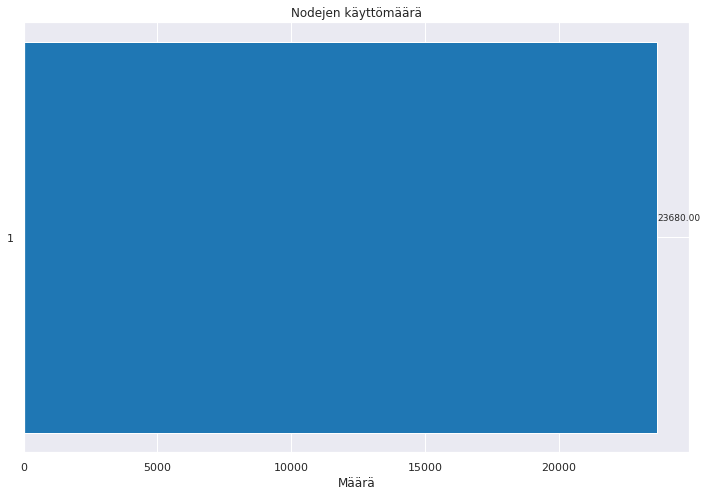

In [38]:
draw_node_amount(df1, 'node_id')

# Tehdään uuten tiedostoon Isolation Forestilla putsatut nodet

Dataframe lenght before: 23752
Dataframe lenght after: 23680
Total outliers detected: 72
Percent removed:    0.3 %
Percent remaining:  99.7 %


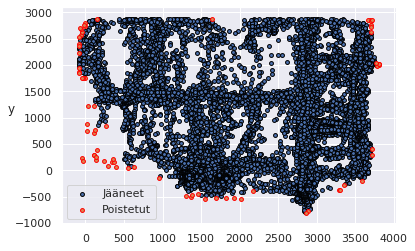

node numero 1 valmis
CPU times: user 5.79 s, sys: 111 ms, total: 5.9 s
Wall time: 4.47 s


,node_id,timestamp,x,y,x_grid,y_grid,grid_id,dayofweek
0,1,2024-06-20 18:20:00,2827,-230,38,15,788,3
1,1,2024-06-20 18:20:00,2918,-201,38,15,788,3
2,1,2024-06-20 18:20:00,2910,-222,38,15,788,3
3,1,2024-06-20 18:20:00,2925,-102,39,16,839,3
4,1,2024-06-20 18:20:00,2912,-93,38,16,838,3


In [14]:
%%time
for i in range(len(df1.node_id.unique())):
    df1 = isolation_forest(df1, 0, .003, i+1)
    print('node numero', i+1, 'valmis')
    
    if i == 0:
        df1.to_csv('./temp_data.csv', index=False)
    else:
        df1.to_csv('./temp_data.csv',mode='a', header=False, index=False)
        
'''df2 = pd.read_csv('./temp_data.csv')
import os
os.remove("./temp_data.csv")
df2.head()'''
df1.head()

# Adding xy_grid values to dataframe (50x50)

In [8]:
%%time
grid_size = 50
df1 = xy_to_grid(df1, df1.x, df1.y, grid_size)
print(df1)

       node_id               timestamp     x    y    z  q  dayofweek  x_grid  \
0            1 2020-06-24 15:20:08.533  2762 -257  100  0          2      36   
1            1 2020-06-24 15:20:08.620  2870 -344  100  0          2      37   
2            1 2020-06-24 15:20:09.623  2916 -344  100  0          2      38   
3            1 2020-06-24 15:20:09.623  2894 -254  100  0          2      38   
4            1 2020-06-24 15:20:10.116  2888 -188  100  0          2      38   
...        ...                     ...   ...  ...  ... ..        ...     ...   
49697        1 2020-07-07 16:36:08.795  1277  -71  100  0          1      18   
49698        1 2020-07-07 16:36:18.795  1278  -77  100  0          1      18   
49699        1 2020-07-07 16:36:27.795  1277  -80  100  0          1      18   
49700        1 2020-07-07 16:36:38.793  1273  -85  100  0          1      18   
49701        1 2020-07-07 16:36:47.793  1272  -86  100  0          1      18   

       y_grid  grid_id  
0           8 

# Write cleaned and diskretized dataframe to mariadb database

In [9]:
%%time
write_df_to_mariadb(df1, 'Testi')

Existing table found. Prepairing to Drop Table named Testi...


Continue? yes/no:  no


Aborting...
CPU times: user 943 µs, sys: 4.05 ms, total: 4.99 ms
Wall time: 3.17 s


# Find and draw exits

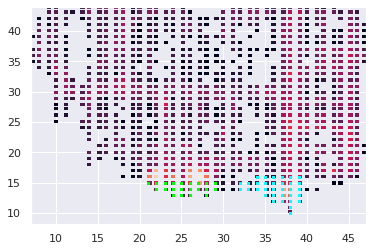

CPU times: user 1.68 s, sys: 148 ms, total: 1.83 s
Wall time: 384 ms


In [16]:
%%time
in_x, in_y = sisään(df1, 'x_grid', 'y_grid')
out_x, out_y = ulos(df1, 'x_grid', 'y_grid')

draw_exits(df1, in_x, in_y, out_x, out_y, 'x_grid', 'y_grid')

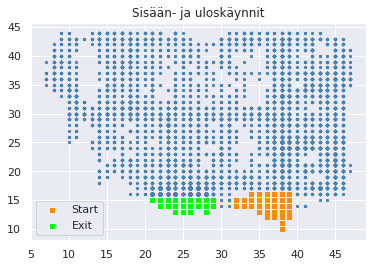

CPU times: user 2.19 s, sys: 147 ms, total: 2.34 s
Wall time: 864 ms


In [36]:
%%time
# Muokataan sisäänkäynnin ja kassojen sijainnit ID-muotoon.
grid_size = 50
in_ID = xy_to_ID(in_x,in_y, grid_size)
out_ID = xy_to_ID(out_x,out_y, grid_size)

# Voidaan tarkistaa sijaintien oikeellisuus
'''sns.scatterplot(x="x_grid", y="y_grid", data = df1)
sns.scatterplot(x=in_x, y=in_y)
sns.scatterplot(x=out_x, y=out_y)
hmax= sns.kdeplot(df1.x_grid, df1.y_grid, cmap="afmhot", shade=True, alpha = 0.7)
hmax.collections[3].set_alpha(0)'''
plt.scatter(df1['x_grid'], df1['y_grid'], color='steelblue', s=5)#np.random.random(3)
plt.scatter(in_x, in_y, color='darkorange', marker='s', s=10, label="Start")
plt.scatter(out_x, out_y, color='lime', marker='s', s=10, label="Exit")
plt.title("Sisään- ja uloskäynnit")
plt.legend()

plt.show()

### Erotetaan kauppareissut toisistaan

In [53]:
%%time
# Haetaan uniikit id:t
u_in_ID = in_ID.unique()
u_out_ID = out_ID.unique()

reitit = erottele_reitit(df1, u_in_ID, u_out_ID)

reitit = poista_lyhyet_reitit(reitit, grid_size)
df_reitit = reitit_dataframeksi(reitit)

CPU times: user 5.15 s, sys: 24 ms, total: 5.17 s
Wall time: 5.17 s


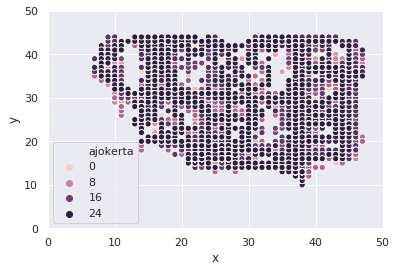

CPU times: user 2.35 s, sys: 148 ms, total: 2.5 s
Wall time: 1.08 s


In [19]:
%%time
# Plotataan kaikki erotellut kauppareissut yhdessä
plot_all_routes(df_reitit, grid_size)

# Poistetaan liiat nopeudet

Uusi taulu:  9378
Poistettuja pisteitä:  14302


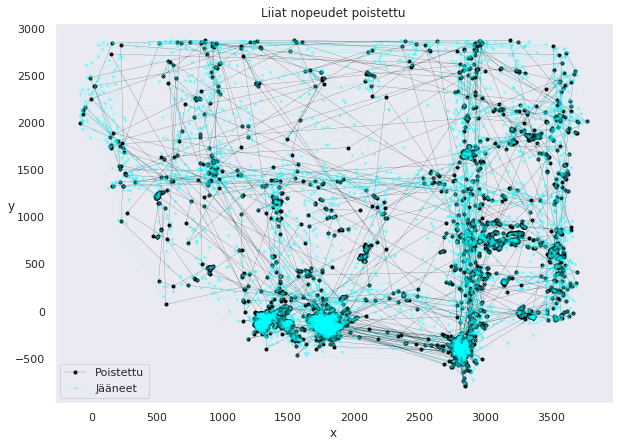

CPU times: user 23.2 s, sys: 4.08 ms, total: 23.2 s
Wall time: 23.2 s


In [15]:
%%time
# Otetaan kopio taulusta piirtämistä varten
dftest = df1.copy()
# Laskee x:n ja y:n oudot nopeudet
uusi_df = velocity.column_vel(dftest, 'x', 'y')
# Piirtää kuvan näistä
velocity.draw_vel(dftest, df1, 'x', 'y')

In [41]:
uusi_df

,node_id,timestamp,x,y,x_grid,y_grid,grid_id,dayofweek,velocity,distance
4,1,2024-06-20 18:20:00,2912,-93,38,16,838,3,1.700149,15.811388
39,1,2024-06-20 18:21:00,2975,2849,39,43,2189,3,0.174771,975.221001
49,1,2024-06-20 18:21:00,2925,2300,39,38,1939,3,1.616483,15.033296
52,1,2024-06-20 18:21:00,2930,2167,39,37,1889,3,1.360119,12.649111
59,1,2024-06-20 18:21:00,2966,1579,39,32,1639,3,1.616483,15.033296
...,...,...,...,...,...,...,...,...,...,...
23674,1,2030-06-20 23:46:00,1732,-94,26,16,826,3,0.107527,1.000000
23675,1,2030-06-20 23:46:00,1733,-95,26,16,826,3,0.152066,1.414214
23676,1,2030-06-20 23:46:00,1731,-96,26,16,826,3,0.240437,2.236068
23677,1,2030-06-20 23:46:00,1730,-94,26,16,826,3,0.240437,2.236068


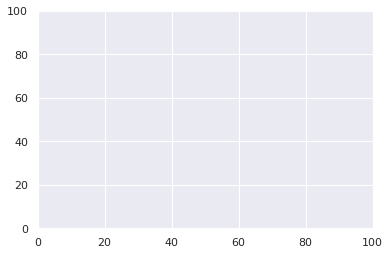

In [198]:
import matplotlib
#matplotlib.use('Qt5Agg') #use Qt5 as backend, comment this line for default backend

from matplotlib import pyplot as plt
from matplotlib import animation

fig = plt.figure()

ax = plt.axes(xlim=(0, 100), ylim=(0, 100))

#lines = [plt.plot([], [])[0] for _ in range(N)] #lines to animate
lines = ax.plot([], [], marker="o", markersize=5, color=np.random.random(3), markerfacecolor=np.random.random(3))

plt.show()
def init():
    #init lines
    line.set_data([], [])

    return (lines) #return everything that must be updated

def animate(i):
    #animate lines
    #line.set_data([0, 2], [10 * j,i])
    for j in range(ajot_len):
        x = df_reitit[df_reitit["ajokerta"] == j]['x']
        y = df_reitit[df_reitit["ajokerta"] == j]['y']
        line.set_data(x[:i], y[:i])

    return (lines) #return everything that must be updated


anim = animation.FuncAnimation(fig, animate, init_func=init,frames=100, interval=20, blit=True)

anim.save('kakka.gif', writer='pillow', fps=60)
plt.show()

ValueError: 'c' argument has 1065 elements, which is not acceptable for use with 'x' with size 1066, 'y' with size 1066.

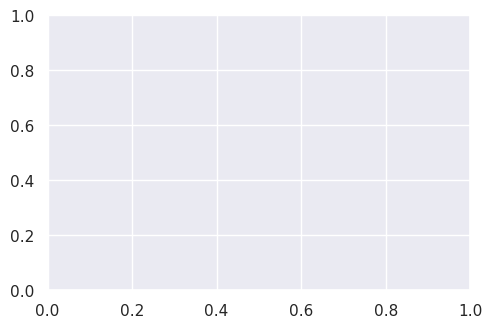

In [158]:
x = df_reitit[df_reitit["ajokerta"] == 3]['x'].values
y = df_reitit[df_reitit["ajokerta"] == 3]['y'].values

import matplotlib.pyplot as plt

import numpy as np
from matplotlib import collections  as mc
from scipy.interpolate import interp1d
from matplotlib.colors import colorConverter

def colored_line_segments(xs,ys,color,mid_colors=False):
    if isinstance(color,str):
        color = colorConverter.to_rgba(color)[:-1]
        color = np.array([color for i in range(len(xs))])        
    segs = []
    seg_colors = []    
    lastColor = [color[0][0],color[0][1],color[0][2]]    
    start = [xs[0],ys[0]]
    end = [xs[0],ys[0]]        
    for x,y,c in zip(xs,ys,color):
        if mid_colors:
            seg_colors.append([(chan+lastChan)*.5 for chan,lastChan in zip(c,lastColor)])        
        else:   
            seg_colors.append(c)        
        lastColor = [c[0],c[1],c[2]]            
        start = [end[0],end[1]]
        end = [x,y]
        segs.append([start,end])
    colors = [(*color,1) for color in seg_colors]
    lc = mc.LineCollection(segs, colors=colors)
    return lc, segs, colors

def segmented_resample(xs,ys,color,n_resample=100,mid_colors=False):    
    n_points = len(xs)
    if isinstance(color,str):
        color = colorConverter.to_rgba(color)[:-1]
        color = np.array([color for i in range(n_points)])   
    n_segs = (n_points-1)*(n_resample-1)        
    xsInterp = np.linspace(0,1,n_resample)
    segs = []
    seg_colors = []
    hiResXs = [xs[0]]
    hiResYs = [ys[0]]
    RGB = color.swapaxes(0,1)
    for i in range(n_points-1):
        fit_xHiRes = interp1d([0,1],xs[i:i+2])
        fit_yHiRes = interp1d(xs[i:i+2],ys[i:i+2])
        
        xHiRes = fit_xHiRes(xsInterp)
        yHiRes = fit_yHiRes(xHiRes)    
        
        hiResXs = hiResXs+list(xHiRes[1:])
        hiResYs = hiResYs+list(yHiRes[1:])
        
        R_HiRes = interp1d([0,1],RGB[0][i:i+2])(xHiRes)        
        G_HiRes = interp1d([0,1],RGB[1][i:i+2])(xHiRes)      
        B_HiRes = interp1d([0,1],RGB[2][i:i+2])(xHiRes)       
                        
        lastColor = [R_HiRes[0],G_HiRes[0],B_HiRes[0]]        
        
        start = [xHiRes[0],yHiRes[0]]
        end = [xHiRes[0],yHiRes[0]]
        if mid_colors: seg_colors.append([R_HiRes[0],G_HiRes[0],B_HiRes[0]])
        for x,y,r,g,b in zip(xHiRes[1:],yHiRes[1:],R_HiRes[1:],G_HiRes[1:],B_HiRes[1:]):
            if mid_colors:
                seg_colors.append([(chan+lastChan)*.5 for chan,lastChan in zip((r,g,b),lastColor)])
            else:            
                seg_colors.append([r,g,b])
            
            lastColor = [r,g,b]            
            start = [end[0],end[1]]
            end = [x,y]
            segs.append([start,end])

    colors = [(*color,1) for color in seg_colors]    
    return segs, colors, [hiResXs,hiResYs]        

def faded_segment_resample(xs,ys,color,fade_len=20,n_resample=100,direction='Head'):      
    segs, colors, hiResData = segmented_resample(xs,ys,color,n_resample)    
    n_segs = len(segs)   
    if fade_len>len(segs):
        fade_len=n_segs    
    if direction=='Head':
        #Head fade
        alphas = np.concatenate((np.zeros(n_segs-fade_len),np.linspace(0,1,fade_len)))
    else:        
        #Tail fade
        alphas = np.concatenate((np.linspace(1,0,fade_len),np.zeros(n_segs-fade_len)))
    colors = [(*color[:-1],alpha) for color,alpha in zip(colors,alphas)]
    lc = mc.LineCollection(segs, colors=colors)
    return segs, colors, hiResData 

    
if __name__ == "__main__":

    NPOINTS = 1066
    RESAMPLE = 1066
    N_FADE = int(RESAMPLE*NPOINTS*0.5)
    N_SEGS = (NPOINTS-1)*(RESAMPLE-1)  

    SHOW_POINTS_AXI_12 = True
    SHOW_POINTS_AXI_34 = True

    np.random.seed(11)
    xs = df_reitit[df_reitit["ajokerta"] == 3]['x'].values
    ys = df_reitit[df_reitit["ajokerta"] == 3]['y'].values

    COLOR='b'

    MARKER = '.'
    #MARKER_COLOR = 'k'
    CMAP = plt.get_cmap('hsv')
    COLORS = np.array([CMAP(i)[:-1] for i in np.linspace(0,1,NPOINTS)])
    MARKER_COLOR = COLORS
    
    N_SCATTER = (NPOINTS-1)*(RESAMPLE-1)+1
    COLORS_LONG = np.array([CMAP(i)[:-1] for i in np.linspace(1/N_SCATTER,1,N_SCATTER)])

    fig = plt.figure(figsize=(12,8),dpi=100)
    ax1 = fig.add_subplot(221) # original data
    lc, segs, colors = colored_line_segments(xs,ys,COLORS,True)
    if SHOW_POINTS_AXI_12: ax1.scatter(xs,ys,marker=MARKER,color=COLORS)
    ax1.add_collection(lc)
    ax1.text(.05,1.05,'Original Data')
    ax1.set_ylim(0,1.2)

    ax2 = fig.add_subplot(222, sharex=ax1, sharey=ax1) # resampled data
    segs, colors, hiResData   = segmented_resample(xs,ys,COLORS,RESAMPLE)
    if SHOW_POINTS_AXI_12: ax2.scatter(hiResData[0],hiResData[1],marker=MARKER,color=COLORS_LONG)
    ax2.add_collection(mc.LineCollection(segs, colors=colors))
    ax2.text(.05,1.05,'Original Data - Resampled')
    ax2.set_ylim(0,1.2)

    ax3 = fig.add_subplot(223, sharex=ax1, sharey=ax1) # resampled with linear alpha fade start to finish

    segs, colors, hiResData = faded_segment_resample(xs,ys,COLORS,fade_len=RESAMPLE*NPOINTS,n_resample=RESAMPLE,direction='Head')
    if SHOW_POINTS_AXI_34: ax3.scatter(hiResData[0],hiResData[1],marker=MARKER,color=COLORS_LONG)
    ax3.add_collection(mc.LineCollection(segs, colors=colors))
    ax3.text(.05,1.05,'Resampled - w/Full length fade')
    ax3.set_ylim(0,1.2)

    ax4 = fig.add_subplot(224, sharex=ax1, sharey=ax1) # resampled with linear alpha fade N_FADE long
    segs, colors, hiResData = faded_segment_resample(xs,ys,COLORS,fade_len=N_FADE,n_resample=RESAMPLE,direction='Head')
    if SHOW_POINTS_AXI_34: ax4.scatter(hiResData[0],hiResData[1],marker=MARKER,color=COLORS_LONG)
    ax4.add_collection(mc.LineCollection(segs, colors=colors))
    ax4.text(.05,1.05,'Resampled - w/{} point fade'.format(N_FADE))
    ax4.set_ylim(0,1.2)

    plt.show()

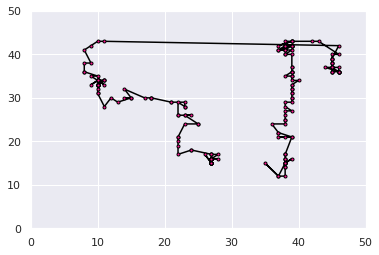

In [28]:
%matplotlib inline



#Linestyle	Description
#'-' or 'solid'	solid line
#'--' or 'dashed'	dashed line
#'-.' or 'dashdot'	dash-dotted line
#':' or 'dotted'	dotted line
#'None' or ' ' or ''	draw nothing

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Suositus 1 node ja esim 1 päivän plot
#x = df_reitit[df_reitit["ajokerta"] == 3]['x']
#y = df_reitit[df_reitit["ajokerta"] == 3]['y']

fig, ax = plt.subplots()
#ax.set_xlim((0, 100))
#ax.set_ylim((0, 100))
line, = ax.plot([], [], marker="o", markersize=3, color='black', markerfacecolor='deeppink')
#plt.scatter(x, y, c=t, cmap='jet')

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    x = df_reitit[df_reitit["ajokerta"] == 7]['x']
    y = df_reitit[df_reitit["ajokerta"] == 7]['y']
    line.axes.axis([0, 50, 0, 50])
    line.set_data(x[:i], y[:i])
    #line.axes.axis([-2000, 6000, -2000, 5000])
    return (line,)

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(x),
                              interval=20, blit=True)
#plt.show()
ani.save('reitti.gif', writer='pillow', fps=60)
ani

Ajokerrat:  21


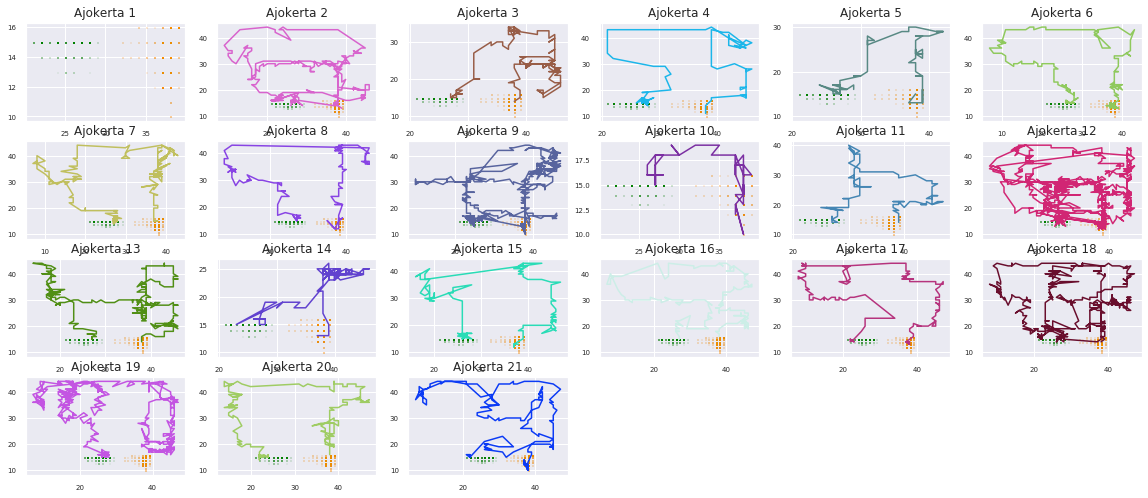

CPU times: user 12.7 s, sys: 644 ms, total: 13.3 s
Wall time: 5.07 s


In [20]:
%%time

import matplotlib.colors as pltc
from random import sample
import matplotlib.animation as animation

ajot = df_reitit["ajokerta"].unique()
ajot_len = max(df_reitit["ajokerta"].unique())

#c = cm.flag(np.linspace(0, 1, ajot_len))
all_colors = [k for k,v in pltc.cnames.items()]

print("Ajokerrat: ",ajot_len)
if ajot_len > 10:
    plt.figure(figsize=(20,(ajot_len/2))) # specifying the overall picture size
elif ajot_len < 10:
    plt.figure(figsize=(20,ajot_len))


for i in range(ajot_len):
    c = sample(all_colors, ajot_len)
    plt.subplot((ajot_len/5)+1,6,i+1)
    plt.plot(df_reitit[df_reitit["ajokerta"] == i]['x'], df_reitit[df_reitit["ajokerta"] == i]['y'], color=np.random.random(3))#np.random.random(3)
    plt.scatter(in_x, in_y, color='darkorange', marker='s', s=1, alpha=0.05)
    plt.scatter(out_x, out_y, color='green', marker='s', s=1,  alpha=0.05)
    plt.title(f"Ajokerta {i+1}")
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    #plt.axis('off')

plt.show()

983


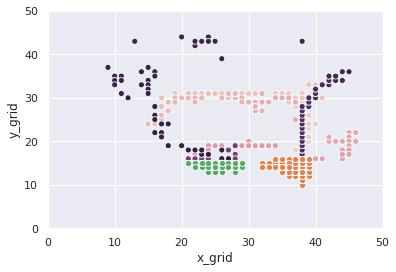

296


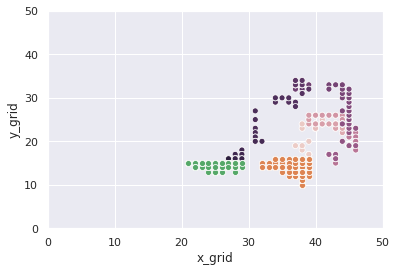

285


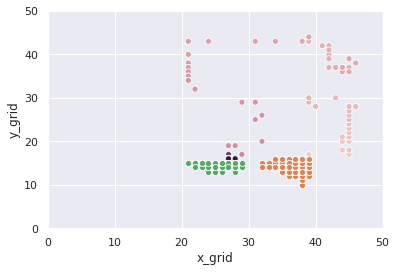

110


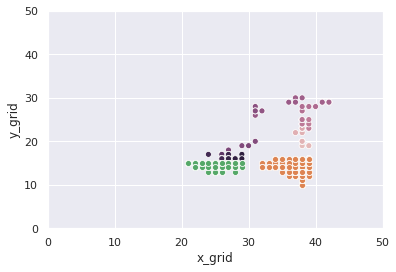

530


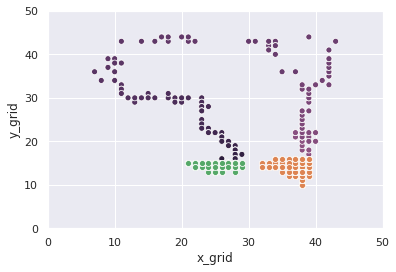

414


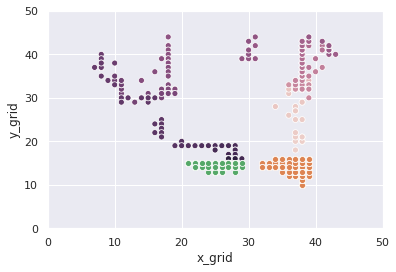

237


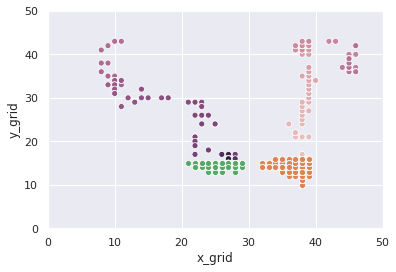

2124


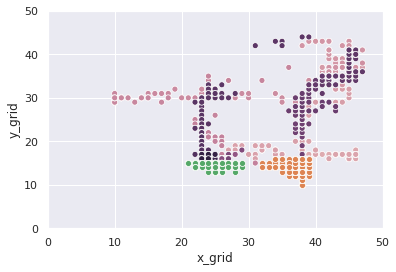

71


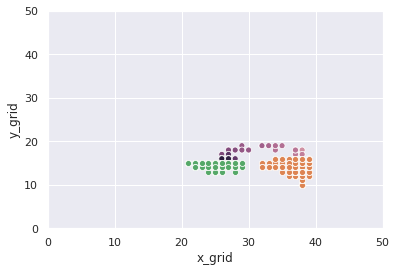

157


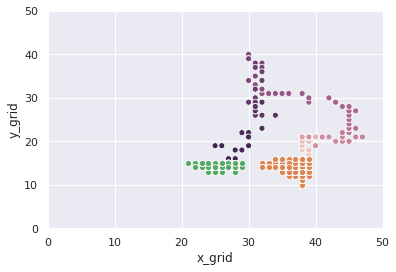

2835


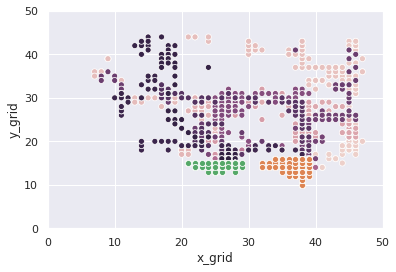

537


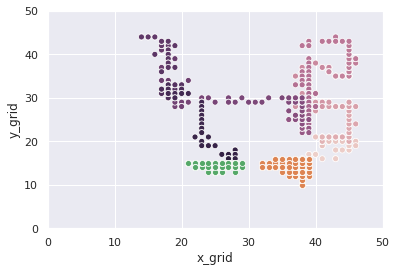

354


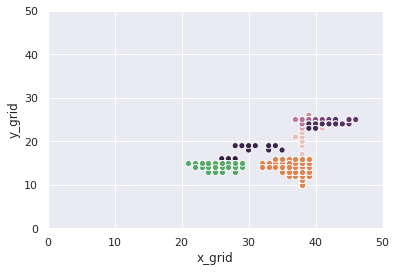

339


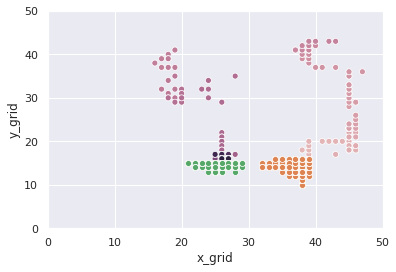

284


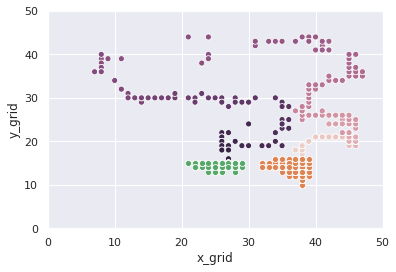

179


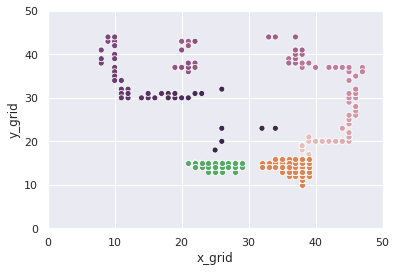

836


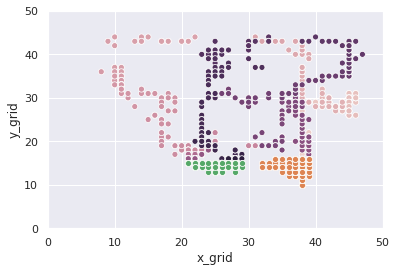

720


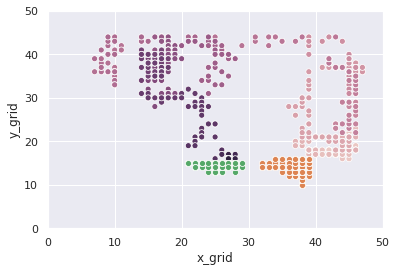

266


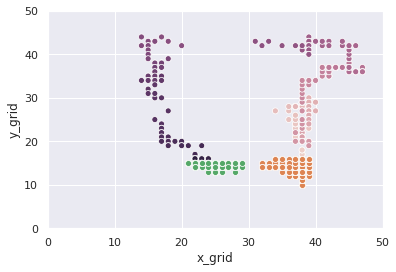

226


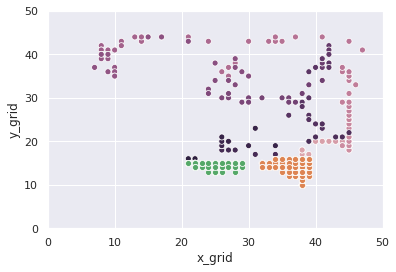

5095


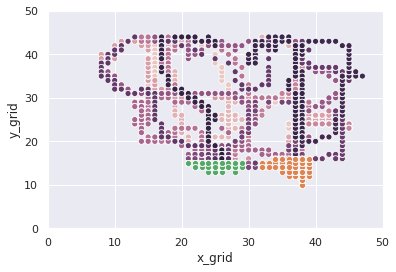

CPU times: user 41.8 s, sys: 3.08 s, total: 44.9 s
Wall time: 6.81 s


In [37]:
%%time
# Plottaa jokaisen kauppareissut erikseen.
plot_unique_routes(df_reitit, grid_size, in_x, in_y, out_x, out_y)   
# Ensimmäisissä on aika paljon häiriötä